[View in Colaboratory](https://colab.research.google.com/github/planewave/coherent_receiver_with_CNN/blob/master/equalization.ipynb)

In [0]:
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import pyplot as plt

In [0]:
#@title
def rrcosdesign(beta, span, sps):
    """
    returns the coefficients, that correspond to a square-root raised 
    cosine FIR filter with rolloff factor specified by beta. The filter 
    is truncated to span symbols, and each symbol period contains sps 
    samples. The order of the filter, sps*span, must be even. 
    modified from:
    https://github.com/veeresht/CommPy/blob/master/commpy/filters.py
    """
    n = sps*span
    rrc = np.zeros(n, dtype=float)
        
    for x in np.arange(n):
        t = (x-n/2)/sps
        if t == 0.0:
            rrc[x] = 1.0 - beta + (4*beta/np.pi)
        elif beta != 0 and t == 1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        elif beta != 0 and t == -1/(4*beta):
            rrc[x] = ((beta/np.sqrt(2))*(((1+2/np.pi)*(np.sin(np.pi/
                     (4*beta)))) + ((1-2/np.pi)*(np.cos(np.pi/(4*beta))))))
        else:
            rrc[x] = ((np.sin(np.pi*t*(1-beta))+4*beta*(t)*np.cos(np.pi*
                     t*(1+beta)))/(np.pi*t*(1-(4*beta*t)*(4*beta*t))))
        
    return rrc

def demod_qpsk(sig):
    """
    demodulation of QPSK signal
    complex 1D array input
    soft max decision output
    """
    out = np.zeros((sig.size, 4))
    x = sig.real
    y = sig.imag
    out[:, 0] = y*(x>y)+x*(x<=y)
    out[:, 1] = y*(-x>y)-x*(-x<=y)
    out[:, 2] = -y*(-x>-y)-x*(-x<=-y)
    out[:, 3] = -y*(x>-y)+x*(x<=-y)
    e_x = np.exp(out-out.max(axis = 1).reshape(-1,1))
    soft_dc = e_x/e_x.sum(axis = 1).reshape(-1,1)
    hard_dc = np.argmax(soft_dc, axis=1)
    return hard_dc, soft_dc

def upsample(x, n):
    """
    increase sample rate by integer factor
    y = upsample(x,n) increases the sample rate of x by 
    inserting n – 1 zeros between samples.
    input is 1D numpy array
    
    """
    zo = np.zeros((len(x), n), dtype=x.dtype)
    zo[:,0] += x
    return zo.flatten()

In [0]:
M = 4
SYMB = 100 # num of symbols
msg = np.random.randint(0, M, SYMB)
sig_mod = np.exp(1j*(np.pi/M+msg*(2*np.pi/M)))
# pluse shaping 
beta = 0.4
span = 6
sps = 32
rrc = rrcosdesign(beta, span, sps)
sig_up = upsample(sig_mod, sps)
sig_pulse = np.convolve(sig_up, rrc)
# plt.plot(sig_pulse.real)
# plt.plot(sig_pulse.imag)
# plt.show()


# up convert
fc = 7.1e3
baud = 1e3
fs = baud*sps # 24kHz
samp_len = len(sig_pulse)
time = np.arange(samp_len)/fs
carrier = np.exp(1j*(2*np.pi*fc*time))
sig_pass = np.real(sig_pulse*carrier)

In [0]:
# channel
hp = np.zeros(5*32) # 5 ms
hp[0], hp[38], hp[90], hp[127] = 1, 0.0, 0.6, 0.0
sig_ch = np.convolve(sig_pass, hp)[0:sig_pass.size]+ \
        0.3*np.random.randn(sig_pass.size)
# plt.plot(hp)
# plt.show()

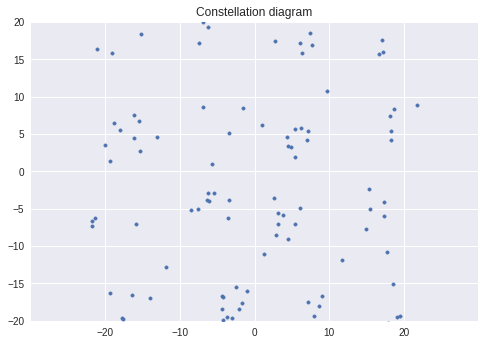

0.99

In [53]:
# receiver side
# down convert to baseband
sig_base = sig_ch*np.conj(carrier)
# sig_filt = sig.upfirdn(rrc, sig_base)
# sig_dn = sig.upfirdn(rrc, sig_base, 1, sps)[span:-span]

sig_filt = np.convolve(sig_base, rrc)
sig_timing = sig_filt[span*sps:-span*sps:sps]


plt.scatter(sig_timing.real, sig_timing.imag, marker='.')
plt.axis('equal')
plt.title('Constellation diagram')
plt.ylim(-20, 20)
plt.xlim(-20, 20)
plt.show()

# deodulation
demod  = demod_qpsk(sig_timing)[0]
symb_err = np.sum(msg == demod)/SYMB
symb_err
# print(msg, demod)